In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import integrate
import math as m
import scipy.linalg as la
import scipy.sparse.linalg as sla

# Волновое #

In [3]:
def Wave(lam, x):
    return np.cos(2*np.pi/lam*x)

def WaveP(lam, x, v, t):
    return Wave(lam, x+v*t)

def WaveN(lam, x, v, t):
    return Wave(lam, x-v*t)

In [20]:
def f1(lam):
    x_min = -2 * np.pi
    x_max = 2 * np.pi
    Nx = 101
    x = []

    for i in range(Nx):
        x.append(x_min + (x_max - x_min)/(Nx-1)*(i))

    t_min = 0
    t_max = 50
    v = 0.05
    Nt = 101
    t = []

    for j in range(Nt):
        t.append(t_min + ((t_max - t_min)/(Nt - 1))*(j))

    M1 = np.zeros((Nt, Nx), dtype=np.float64)
    M2 = np.zeros((Nt, Nx), dtype=np.float64)

    for i in range(Nt):
        for j in range(Nx):
            M1[i, j] = WaveP(lam, x[j], v, t[i])
            M2[i, j] = WaveN(lam, x[j], v, t[i])
            
    fig,axs = plt.subplots(1,2, figsize=(10, 10))
    axs[0].plot(x, M1[0,:],'red', x, M1[39,:],'blue', x, M1[79,:],'green')
    axs[1].plot(x, M2[0,:],'red', x, M2[39,:],'blue', x, M2[79,:],'green')

    X, Y = np.meshgrid(x, t)

    fig,axs = plt.subplots(1,2, subplot_kw=dict(projection="3d"), figsize=(10, 10))
    axs[0].plot_surface(X, Y, M1)
    axs[1].plot_surface(X, Y, M2)
    
    fig,axs = plt.subplots(2,2, figsize=(10, 10))
    axs[0, 0].contourf(M1, 15)
    axs[0, 1].contourf(M2, 15)
    axs[1, 0].plot(x, M1[0,:])
    axs[1, 1].plot(t, M1[:,0])
    
    i1 = np.where(M1[:,0] <= M1[0,0])[0][1]
    i2 = np.where(M1[0,:] <= M1[0,0])[0][1]
    T1 = t[np.where(M1[i1:,0] >= M1[0,0])[0][1]] - t_min
    T2 = x[np.where(M1[0,i2:] >= M1[0,0])[0][1]] - x_min
    
    print(T1, T2, T2/T1)

9.5 0.5026548245743667 0.05291103416572281


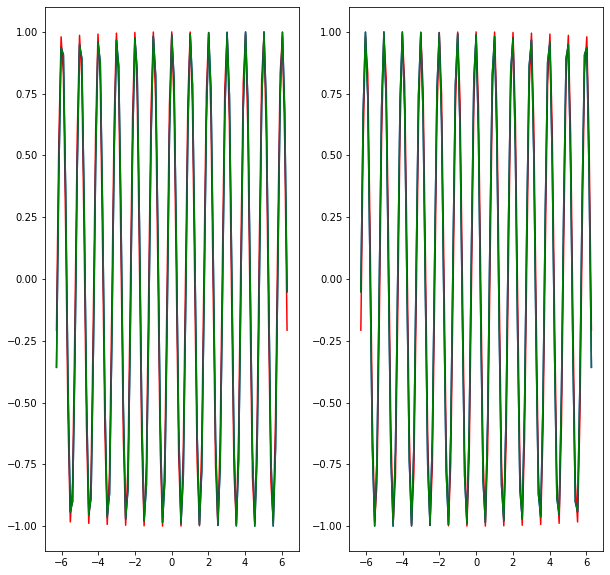

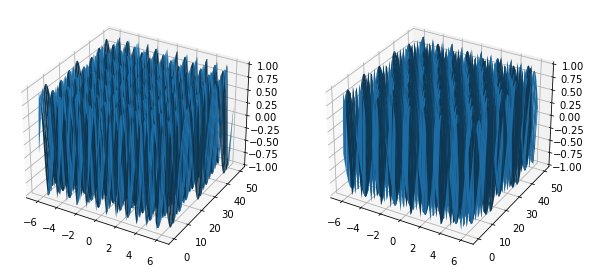

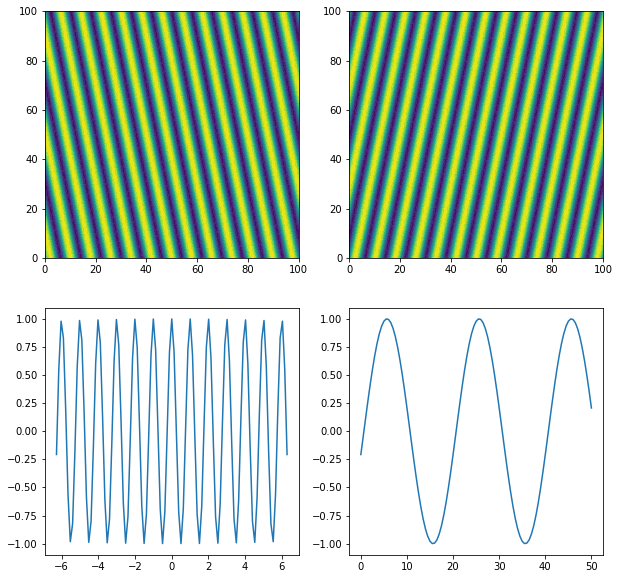

In [21]:
f1(1)

19.5 1.0053096491487334 0.05155434098198633


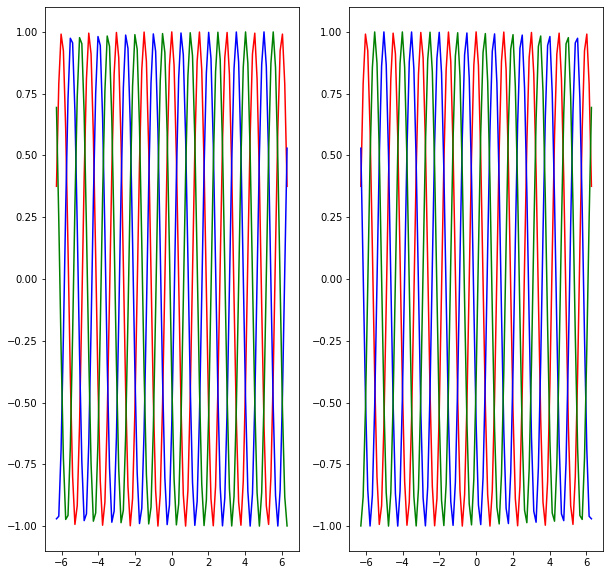

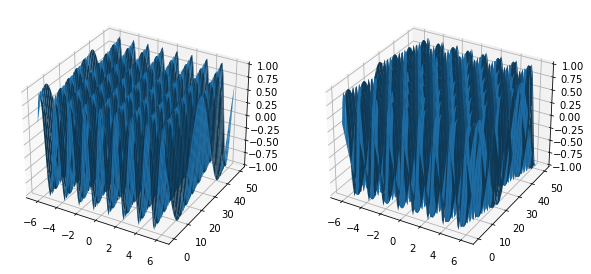

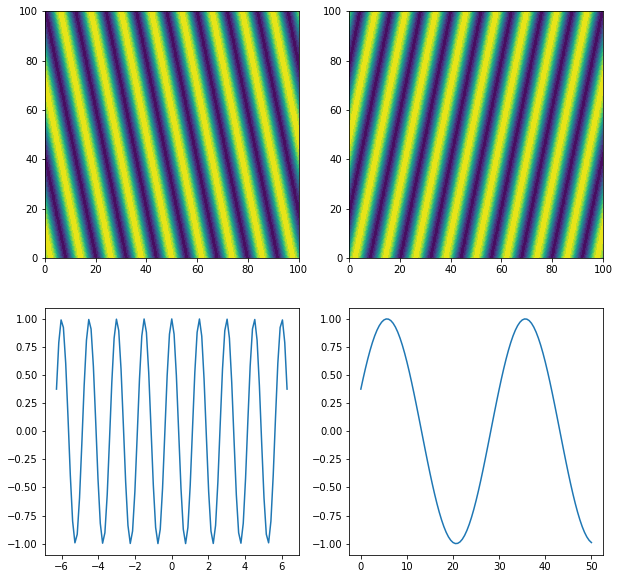

In [22]:
f1(1.5)

# Интенсивность #

In [25]:
def Intensity1(Lambda, N, A, R0, r, Nb):
    
    Rr= np.zeros(N, dtype=np.float64)
    f = np.zeros(Nb, dtype=np.float64)
    
    for i in range(N):
        Rr[i] = np.linalg.norm(r - R0[:,i])
        
    for i in range(Nb):
        su = 0
        
        for j in range(N):
            su += (A[j]/Rr[j]*np.cos(2*np.pi/Lambda*Rr[j]-2*np.pi/Nb*i))
        f[i] = su**2
        
    return np.mean(f)

In [32]:
def Onegap(Lm):
    N = 21
    A = [1 for i in range(N)]
    lam = 5e-4

    R = np.zeros((N, 3))
    for i in range(21):
        R[:, 2][i] = -0.01 + i * 0.001
    R = R.T

    Np = 300
    z_min = -10
    z_max = 10

    z = np.zeros(Np, dtype=np.float64)

    for i in range(Np):
        z[i] = z_min + (z_max - z_min) / (Np - 1) * i

    L = Lm
    Nb = 3
    I1 = np.zeros(Np, dtype=np.float64)

    for i in range(Np):
        r = np.array([0, L, z[i]]).T
        I1[i] = Intensity1(lam, N, A, R, r, Nb)

    I1max = np.amax(I1)
    plt.plot(z, I1 / I1max)

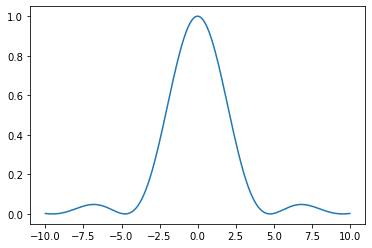

In [33]:
Onegap(200)

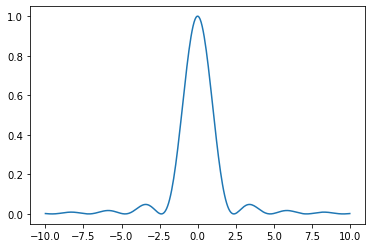

In [34]:
Onegap(100)

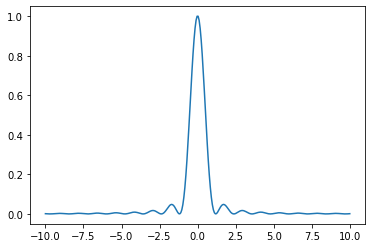

In [35]:
Onegap(50)

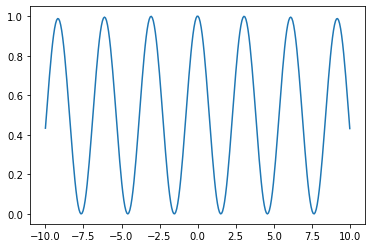

In [36]:
# Two gaps
N = 40
A = [1 for i in range(N)]
Lambda = 5e-4

R = np.zeros((N, 3))
for i in range(N//2):
    R[:, 2][i] = -0.05 - N/4 * 0.0001 + i * 0.0001
    
for i in range(N//2, N):
    R[:, 2][i] = 0.05 + N/4 * 0.0001 - i * 0.0001
R = R.T

Np = 300
z_min = -10
z_max = 10

z = np.zeros(Np, dtype=np.float64)

for i in range(Np):
    z[i] = z_min + (z_max - z_min) / (Np - 1) * i
    
L = 600
Nb = 3
I1 = np.zeros(Np, dtype=np.float64)

for i in range(Np):
    r = np.array([0, L, z[i]]).T
    I1[i] = Intensity1(Lambda, N, A, R, r, Nb)
    
I1max = np.amax(I1)
plt.plot(z, I1/I1max)

# Траектория #

In [40]:
def CoeffRefraction(a, alfa, beta, y):
    return (1 + a * y**alfa)**beta

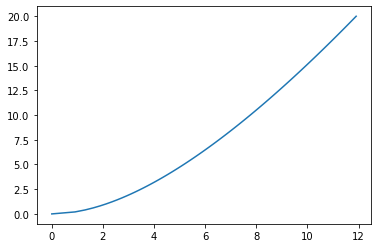

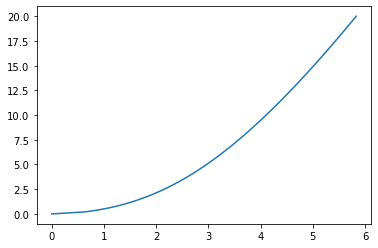

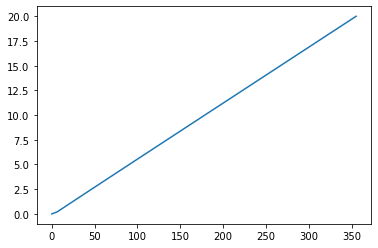

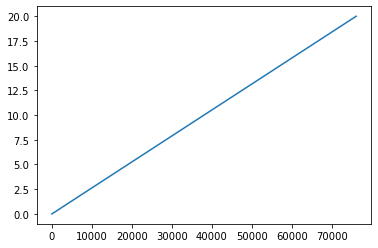

In [41]:
N = 4
param = [[1, 1, 0.5], [1, 1, 1], [2, 2, 2], [2.5, 3, 3.5]]
Np = 100
Xball = np.zeros((N, Np), dtype=np.float64)
Yball = np.zeros((N, Np), dtype=np.float64)

j = 0
for a, alfa, beta in param:
    y_min = 1e-5
    y_max = 20
    
    y = []

    for i in range(Np):
        y.append(y_min + (y_max - y_min)/(Np-1)*(i))

    Nk = 1000

    Y = np.zeros(Nk, dtype=np.float64)
    Z = np.zeros(Nk, dtype=np.float64)

    Xb = np.zeros(Np, dtype=np.float64)
    Yb = np.zeros(Np, dtype=np.float64)

    for i in range(Np):
        for k in range(Nk):
            Y[k] = y_min + (y[i] - y_min)/(Nk -1)*(k)
            Z[k] = 1/((CoeffRefraction(a, alfa, beta, Y[k])**2-1)**0.5)

        Xb[i] = np.trapz(Z, Y)
        Yb[i] = Y[Nk-1]
    Xball[j] = Xb
    Yball[j] = Yb
    j += 1
    
fig = []
ax = []

for i in range(N):
    fig.append(plt.figure())
    ax.append(fig[i].add_subplot(111))
    ax[i].plot(Xball[i], Yball[i])